In [1]:
import os
from tqdm.notebook import tqdm
from random import shuffle
import datetime

import matplotlib.pyplot as plt
import numpy as np

import torch
import gsplat
from PIL import Image
from torch import optim
import torchvision.transforms as transforms

from src.model.gaussians import Gaussians
from src.data.colmap import ColmapDataSet

In [2]:
ROOT_DIR = '/media/jip/T7/thesis/code/data/'
if not os.path.isdir(ROOT_DIR):
    ROOT_DIR = '/home/jip/data1/'
ROOT_DIR += "bicycle"

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
try:
    torch.cuda.set_device(DEVICE)
except:
    print("!WARNING! could not set cuda device, falling back to default")

LOAD_CKPT = None
LOAD_CKPT = "models/model_wed24jan1707_30000its.ckpt"

In [3]:
def image_path_to_tensor(image_path:str):

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor

def tensor_to_ndarray(image:torch.Tensor) -> np.ndarray:
    return image.detach().cpu().numpy()

def ndarray_to_Image(image:np.ndarray) -> Image.Image:
    return Image.fromarray((image*255).astype(np.uint8))

def tensor_to_Image(image:torch.Tensor) -> Image.Image:
    return ndarray_to_Image(tensor_to_ndarray(image))


def train(
    model:Gaussians,
    dataset:ColmapDataSet,
    device=DEVICE,
    num_iterations:int=7_000,
) -> tuple[Gaussians,dict]:

    # Set up optimizer
    # From https://github.com/nerfstudio-project/gsplat/issues/87#issuecomment-1862540059
    scheduler = torch.optim.lr_scheduler.ChainedScheduler(
        [
            # 10 warmup iters
            torch.optim.lr_scheduler.LinearLR(
                model.optimizer, start_factor=0.01, total_iters=10
            ),
            # multiply lr by 1/3 at 50% and 75%
            torch.optim.lr_scheduler.MultiStepLR(
                model.optimizer,
                milestones=[
                    num_iterations // 2,
                    num_iterations * 3 // 4,
                ],
                gamma=0.33,
            ),
        ]
    )
    loss_fn = torch.nn.MSELoss()

    # Output package
    out = {
        'losses':[],
        'lr':[]
    }

    # Use progress bar
    pbar = tqdm(total=num_iterations, desc="Training", smoothing=.5)

    test_cam = dataset.cameras[1]
    test_cam.to(device)
    tensor_to_Image(test_cam.gt_image).save(f'renders/gt_{test_cam.name}')

    # Set up epoch
    loss_accum=0.
    loss_norm=0

    dataset_cycle = dataset.cycle()

    for iter in range(1,num_iterations+1):

        camera = next(dataset_cycle)
        camera.to(device)

        model.optimizer.zero_grad()

        # Forward pass
        rendering_pkg = model.render(camera)
        loss = loss_fn(rendering_pkg['rendering'], camera.gt_image)

        # Backward pass
        loss.backward()
        model.optimizer.step()

        with torch.no_grad():

            if iter <= 15_000:
                # Densify
                model.update_densification_stats(
                    xys=rendering_pkg['xys'],
                    radii=rendering_pkg['radii'],
                    visibility_mask=rendering_pkg['visibility_mask']
                )
                if iter >= 1000 and iter%500 == 0:
                    model.densify(
                        grad_threshold=2e-8,
                        max_scale=0.01 * dataset.scene_extend,
                        min_opacity=0.005,
                    )

                if iter%3000 == 0:
                    model.reset_opacity()

            # Update batch info
            loss_accum += loss.item()
            loss_norm += 1

            pbar.update(1)

            if iter%10 == 0:
                # Compute epoch loss
                _loss = loss_accum / loss_norm
                _lr = scheduler.get_last_lr()[0]

                out['losses'].append(_loss)
                out['lr'].append(_lr)
                loss_accum = 0.
                loss_norm = 0

                pbar.set_postfix({
                    'loss':f"{_loss:.2e}",
                    'lr':f"{_lr:.1e}",
                    '#splats': model.num_points,
                }, refresh=False)

            if (iter-1)%100 == 0:
                test_cam.to(device)
                # tensor_to_Image(model.render(camera, bg=torch.zeros(3,device=device))).save(f'renders/epoch{epoch}_{camera.name}')
                tensor_to_Image(model.render(test_cam, bg=torch.zeros(3,device=device))['rendering']).save(f'renders/latest_{test_cam.name}')
                test_cam.to('cpu')

        # End iter
        scheduler.step()
        camera.to('cpu')
        torch.cuda.empty_cache()

    pbar.close()

    return out

In [4]:
dataset = ColmapDataSet(
    root_dir=ROOT_DIR,
    img_folder='images_8',
    device='cpu',
)
print(f"Found {len(dataset)} cameras")

Reading cameras...
Reading images...
Parsing cameras and images...
Found 194 cameras


In [5]:
model = Gaussians.from_colmap(
    path_to_points3D_file=os.path.join(ROOT_DIR,'sparse/0/points3D.txt'),
    device=DEVICE,
)

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

#################### 
Densifying... [started with 55933 splats]
39850 splats selected for cloning/splitting
4 splats selected for splitting
Pruning 0 splats
Now has 135633 splats
#################### 
Densifying... [started with 135633 splats]
10853 splats selected for cloning/splitting
4 splats selected for splitting
Pruning 0 splats
Now has 157339 splats
#################### 
Densifying... [started with 157339 splats]
24721 splats selected for cloning/splitting
36 splats selected for splitting
Pruning 0 splats
Now has 206781 splats
#################### 
Densifying... [started with 206781 splats]
16962 splats selected for cloning/splitting
130 splats selected for splitting
Pruning 0 splats
Now has 240705 splats
#################### 
Densifying... [started with 240705 splats]
8223 splats selected for cloning/splitting
280 splats selected for splitting
Pruning 1 splats
Now has 257150 splats
#################### 
Densifying... [started with 257150 splats]
4924 splats selected for cloning

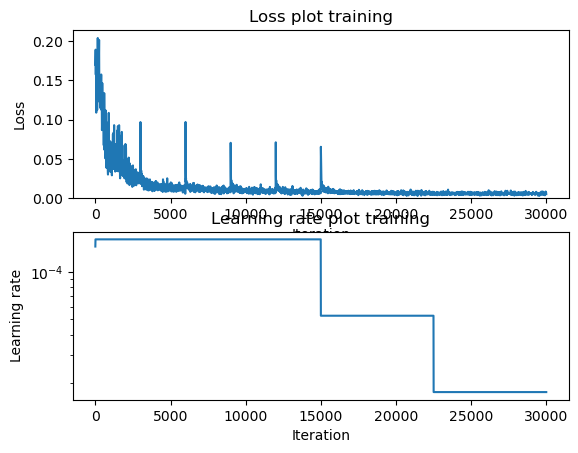

In [6]:
if LOAD_CKPT is None:
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    out = train(
        model,
        dataset,
        num_iterations=30_000,
        device=DEVICE,
    )
    plt.subplot(2,1,1)
    plt.plot(np.arange(len(out['losses']))*10,out['losses'])
    plt.ylim(0)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss plot training")

    plt.subplot(2,1,2)
    plt.plot(np.arange(len(out['lr']))*10, out['lr'])
    # plt.ylim(0)
    plt.yscale('log')
    plt.xlabel("Iteration")
    plt.ylabel("Learning rate")
    plt.title("Learning rate plot training")

    plt.show()
    fname = "models/model_{}.ckpt".format(datetime.datetime.now().strftime('%a%d%b%H%M').lower())
    torch.save(model.state_dict(),fname)
else:
    model.load_state_dict(torch.load(LOAD_CKPT, map_location=DEVICE))

In [11]:
print("Saving results..")
out_dir = os.path.join(os.getcwd(), "renders")

rendering = []
nrow = len(dataset)

cameras = sorted(dataset, key=lambda cam:cam.name)

for camera in cameras:

    camera.to(DEVICE)
    bg = torch.zeros(3,dtype=torch.float, device=DEVICE)

    I = ndarray_to_Image(np.hstack((
        tensor_to_ndarray(camera.gt_image),
        tensor_to_ndarray(model.render(camera, bg=bg)['rendering'])
    )))

    I.save(os.path.join(out_dir,camera.name))
    # rendering.append(I)

# rendering[0].save(
#     os.path.join(out_dir,"rendering.gif"),
#     save_all=True,
#     append_images=rendering[2::2],
#     optimize=False,
#     duration=500,
#     loop=0,
# )

print("Results saved")

Saving results..
Results saved


In [8]:
raise NotImplementedError("Not working rn")

from scipy.spatial.transform import Slerp,Rotation
from src.utils.camera import Camera
from scipy.interpolate import LinearNDInterpolator

cameras = sorted(dataset, key=lambda cam:cam.name)[:9:2]

rotmats = Rotation.from_matrix([camera.R for camera in cameras])
slerp = Slerp(range(len(rotmats)),rotmats)

np.interp()

times = np.linspace(0,len(cameras)-1.1,20)

renders = []

for t in T:
    tint = int(t)
    tfrac = t - tint

    c1 = cameras[tint]
    c2 = cameras[tint+1]

    camera = Camera(
        gt_image=None,
        R=slerp(t).as_matrix(),
        t=tfrac * c1.t + (1-tfrac)*c2.t,
        fovx=c1.fovx, fovy=c1.fovy,
        H=c1.H, W=c1.W,
        device=DEVICE
    )

    renders.append(ndarray_to_Image(np.hstack((
        tensor_to_ndarray(c1.gt_image if tfrac<.5 else c2.gt_image),
        tensor_to_ndarray(model.render(camera, bg=bg))
    ))))

renders[0].save(
    os.path.join(out_dir,"rendering_fancy.gif"),
    save_all=True,
    append_images=renders[1:],
    optimize=False,
    duration=500//60,
    loop=0,
)

NotImplementedError: Not working rn